In [1]:
import numpy as np
import utm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm
import linecache
import my_functions as mf
from scipy.ndimage import gaussian_filter
from scipy.interpolate import RegularGridInterpolator

In [2]:
%matplotlib inline

### Open model 1 - modEM 

In [3]:
file = '//home/flora/Documents/Flora/bolivia_project/interpolation-codes/interpolation_misc/inv_datasynt05_NLCG_063.rho'

#### Get resistivity values 

In [4]:
ld=linecache.getline(file, 2)
lx=linecache.getline(file, 3)
ly=linecache.getline(file, 4)
lz=linecache.getline(file, 5)
dim=ld.split()
nx=int(dim[0])
ny=int(dim[1])
nz=int(dim[2])
#vecteur de taille de maille
hx=np.hstack(float(lx.split()[i]) for i in np.arange(nx) )
hy=np.hstack(float(ly.split()[i]) for i in np.arange(ny) )
hz=np.hstack(float(lz.split()[i]) for i in np.arange(nz) )

#model values
ind=7
rho = np.zeros((nx,ny,nz))

for k in range(nz):
    for j in range(ny):
        l=linecache.getline(file, ind)
        rho[:,j,k]=np.hstack(float(l.split()[i]) for i in np.arange(nx) )[::-1]
        ind = ind+1        
    ind = ind+1
    
rho = (np.e**rho) 

In [5]:
print('Shape of model1',rho.shape)

Shape of model1 (54, 69, 80)


#### Transform coordinates - lat lon to utm 

In [6]:
refE,refN,zone,l = utm.from_latlon(-23.965, -69.475)

#Position centre des mailes (utm & lat/lon)
ctx=np.ones(len(hx))
for i in np.arange(len(hx)):
    ctx[i]=(sum(hx[0:i])+sum(hx[0:i+1]))/2+refN
    
cty=np.ones(len(hy))
for i in np.arange(len(hy)):
    cty[i]=(sum(hy[0:i])+sum(hy[0:i+1]))/2+refE

ctz=np.ones(len(hz))
for i in np.arange(len(hz)):
    ctz[i]=(sum(hz[0:i])+sum(hz[0:i+1]))/2

#ctz = ctz*(-1)

Xla=np.zeros(len(ctx))
Ylon=np.zeros(len(cty))

In [7]:
# import MT stations coordinates

path = '/home/flora/Documents/Flora/bolivia_project/interpolation-codes/interpolation_misc/coord'
data = np.loadtxt(path,dtype='float',usecols=(0,1,2))

stn = data[:,0]
lat = data[:,1]
lon = data[:,2]

Xla=np.zeros(len(lat))
Ylon=np.zeros(len(lon))
for j in range(len(lat)):
    for i in range(len(lon)):
        U=utm.from_latlon(lat[j],lon[i],zone)
        Xla[i]=U[0]
        Ylon[j]=U[1]


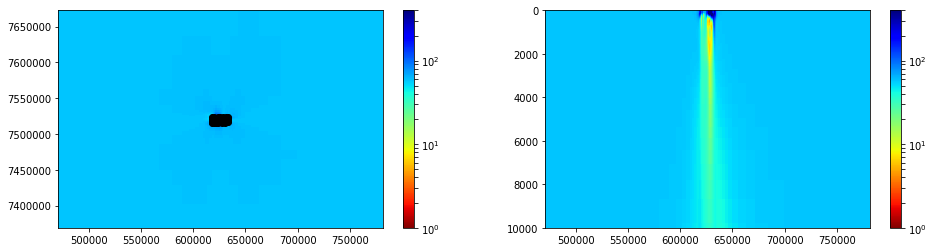

In [8]:
cmap = plt.cm.jet
cmap_r = mf.reverse_colourmap(cmap)

east,north = np.meshgrid(cty,ctx)
depth,east1 = np.meshgrid(ctz,cty)

z_plot = np.argmin(np.abs(ctz-750))
x_plot = np.argmin(np.abs(ctx-7519000))

plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
plt.pcolor(east,north,rho[:,:,z_plot],cmap=cmap_r,norm = LogNorm(vmin=1, vmax=400))
plt.plot(Xla,Ylon,'ko')
#plt.plot(x1,y1,'ko')
#plt.plot(x0,y0,'ro')
plt.colorbar()

plt.subplot(1,2,2)
plt.pcolor(east1,depth,rho[x_plot,:,:],cmap=cmap_r,norm = LogNorm(vmin=1, vmax=400))
plt.ylim(10000,0)
plt.colorbar()
plt.show()

### Select area from model

In [9]:
#north
xmin = 7515000.
xmax = 7524000.
#east
ymin = 618000.
ymax = 634000.

zmin = 0.
zmax = 5000.

In [10]:
xgrid,ygrid,zgrid,xa,ya,za,rho_n = mf.select_area(xmin,xmax,ymin,ymax,zmin,zmax,ctx,cty,ctz,rho)

In [11]:
print('New shape',rho_n.shape)

New shape (20, 36, 51)


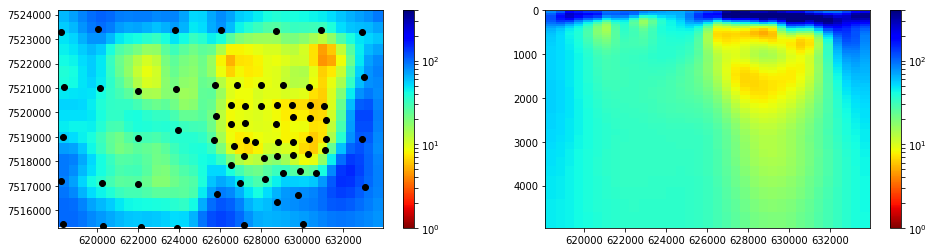

In [12]:
cmap = plt.cm.jet
cmap_r = mf.reverse_colourmap(cmap)

east,north = np.meshgrid(ya,xa)
depth,east1 = np.meshgrid(za,ya)

z_plot = np.argmin(np.abs(za-750))
x_plot = np.argmin(np.abs(xa-7519000))

plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
plt.pcolor(east,north,rho_n[:,:,z_plot],cmap=cmap_r,norm = LogNorm(vmin=1, vmax=400))
plt.plot(Xla,Ylon,'ko')
#plt.plot(x1,y1,'ko')
#plt.plot(x0,y0,'ro')
plt.colorbar()

plt.subplot(1,2,2)
plt.pcolor(east1,depth,rho_n[x_plot,:,:],cmap=cmap_r,norm = LogNorm(vmin=1, vmax=400))
plt.ylim(np.max(za),0)
plt.colorbar()
plt.show()

### Define interpolating coordinates

In [13]:
# #Interpolation points

dx0 = (xa[1:]+xa[:-1])/2
dy0 = (ya[1:]+ya[:-1])/2
dz0 = (za[1:]+za[:-1])/2

# dx1 = np.copy(x1)
# dy1 = np.copy(y1)
# dz1 = np.copy(z1)

x0n = len(dx0)
y0n = len(dy0)
z0n = len(dz0)

X0,Y0,Z0 = np.meshgrid(dx0,dy0,dz0,indexing='ij')

x0 = np.ravel(X0)
y0 = np.ravel(Y0)
z0 = np.ravel(Z0)

### Interpolate

In [14]:
my_interpolating_function = RegularGridInterpolator((xa, ya, za), rho_n, method='linear')

In [15]:
pts = np.array([])

for i in range(len(x0)):
    aux = np.array([x0[i],y0[i],z0[i]])
    pts = np.hstack((pts,aux))
    
pts = pts.reshape(len(x0),3)

In [16]:
model1_int = my_interpolating_function(pts)

In [17]:
model1_int = model1_int.reshape(x0n,y0n,z0n)

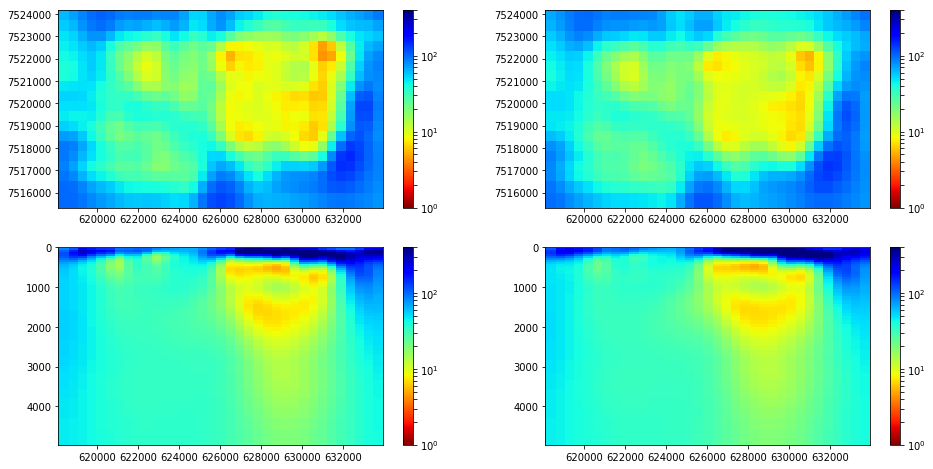

In [18]:
plt.figure(figsize=(16,8))

plt.subplot(2,2,1)
plt.pcolor(east,north,rho_n[:,:,z_plot],cmap=cmap_r,norm = LogNorm(vmin=1, vmax=400))
#plt.plot(x1,y1,'ko')
#plt.plot(x0,y0,'ro')
plt.colorbar()

plt.subplot(2,2,2)
plt.pcolor(east,north,model1_int[:,:,z_plot],cmap=cmap_r,norm = LogNorm(vmin=1, vmax=400))
#plt.plot(x1,y1,'ko')
#plt.plot(x0,y0,'ro')
plt.colorbar()

plt.subplot(2,2,3)
plt.pcolor(east1,depth,rho_n[x_plot,:,:],cmap=cmap_r,norm = LogNorm(vmin=1, vmax=400))
plt.ylim(np.max(za),0)
plt.colorbar()

plt.subplot(2,2,4)
plt.pcolor(east1,depth,model1_int[x_plot,:,:],cmap=cmap_r,norm = LogNorm(vmin=1, vmax=400))
plt.ylim(np.max(za),0)
plt.colorbar()

plt.show()

### Open model 2

In [19]:
file = '/home/flora/Dropbox/IUEM/bolivia_project/ModEM/testes_forward/inv/inv_datasint02_NLCG_141.rho'

In [20]:
ld=linecache.getline(file, 2)
lx=linecache.getline(file, 3)
ly=linecache.getline(file, 4)
lz=linecache.getline(file, 5)
dim=ld.split()
nx=int(dim[0])
ny=int(dim[1])
nz=int(dim[2])
#vecteur de taille de maille
hx=np.hstack(float(lx.split()[i]) for i in np.arange(nx) )
hy=np.hstack(float(ly.split()[i]) for i in np.arange(ny) )
hz=np.hstack(float(lz.split()[i]) for i in np.arange(nz) )

#model values
ind=7
rho2 = np.zeros((nx,ny,nz))

for k in range(nz):
    for j in range(ny):
        l=linecache.getline(file, ind)
        rho2[:,j,k]=np.hstack(float(l.split()[i]) for i in np.arange(nx) )[::-1]
        ind = ind+1        
    ind = ind+1
    
rho2 = (np.e**rho2) 

#### Transform coordinates - lat lon to utm  

In [21]:
refE,refN,zone,l = utm.from_latlon(-23.965, -69.475)

#Position centre des mailes (utm & lat/lon)
ctx=np.ones(len(hx))
for i in np.arange(len(hx)):
    ctx[i]=(sum(hx[0:i])+sum(hx[0:i+1]))/2+refN
    
cty=np.ones(len(hy))
for i in np.arange(len(hy)):
    cty[i]=(sum(hy[0:i])+sum(hy[0:i+1]))/2+refE

ctz=np.ones(len(hz))
for i in np.arange(len(hz)):
    ctz[i]=(sum(hz[0:i])+sum(hz[0:i+1]))/2

#ctz = ctz*(-1)

Xla=np.zeros(len(ctx))
Ylon=np.zeros(len(cty))

### Select area from model

In [22]:
#north
xmin = 7515000.
xmax = 7524000.
#east
ymin = 618000.
ymax = 634000.

zmin = 0.
zmax = 5000.

In [23]:
xgrid2,ygrid2,zgrid2,xa2,ya2,za2,rho2_n = mf.select_area(xmin,xmax,ymin,ymax,zmin,zmax,ctx,cty,ctz,rho2)

### Interpolate

In [24]:
my_interpolating_function = RegularGridInterpolator((xa2, ya2, za2), rho2_n, method='linear')

In [25]:
model2_int = my_interpolating_function(pts)

In [26]:
model2_int = model2_int.reshape(x0n,y0n,z0n)

In [36]:
# choose depth and yz slice

z_plot = np.argmin(np.abs(za-1500))
x_plot = np.argmin(np.abs(xa-7519000))

### Plot both models 

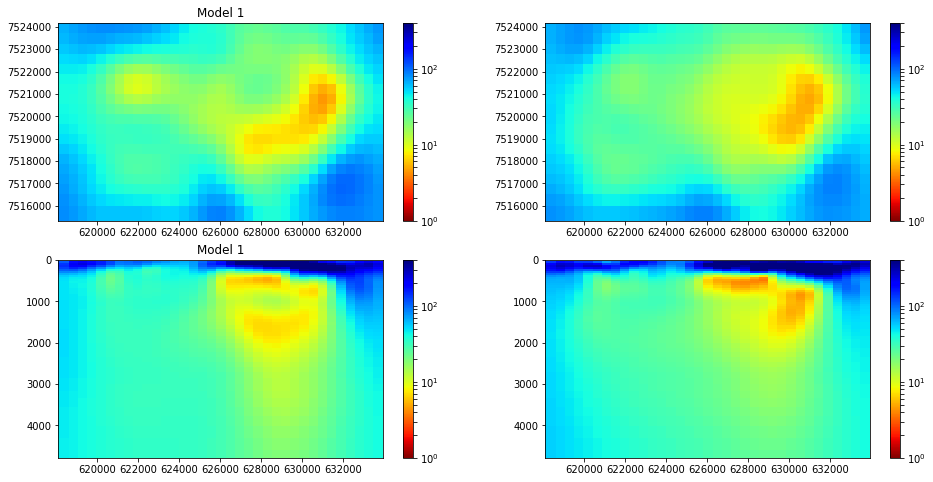

In [40]:
plt.figure(figsize=(16,8))

plt.subplot(2,2,1)
plt.pcolor(east,north,model1_int[:,:,z_plot],cmap=cmap_r,norm = LogNorm(vmin=1, vmax=400))
#plt.plot(x1,y1,'ko')
#plt.plot(x0,y0,'ro')
plt.title('Model 1')
plt.colorbar()

plt.subplot(2,2,2)
plt.pcolor(east,north,model2_int[:,:,z_plot],cmap=cmap_r,norm = LogNorm(vmin=1, vmax=400))
#plt.plot(x1,y1,'ko')
#plt.plot(x0,y0,'ro')
plt.colorbar()

plt.subplot(2,2,3)
plt.pcolor(east1,depth,model1_int[x_plot,:,:],cmap=cmap_r,norm = LogNorm(vmin=1, vmax=400))
plt.ylim(np.max(dz0),0)
plt.title('Model 1')
plt.colorbar()

plt.subplot(2,2,4)
plt.pcolor(east1,depth,model2_int[x_plot,:,:],cmap=cmap_r,norm = LogNorm(vmin=1, vmax=400))
plt.ylim(np.max(dz0),0)
plt.colorbar()

plt.show()